## 임계점 변화에 따른 평가지표&ROC 변화

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score

import warnings
warnings.filterwarnings('ignore')

In [2]:
df =sns.load_dataset('titanic')

In [3]:
df_sp=df[['survived','pclass','age','sibsp','parch','fare']]
df_sp.dropna(inplace=True) # 임의로 제거

### 모델 학습&예측

- 학습/평가 데이터 분리

In [4]:
X_train, X_test, y_train, y_test = train_test_split(df_sp.drop('survived',axis=1), df_sp['survived'], test_size=0.3, random_state=111)

In [5]:
#평가지표 함수
def get_clf_eval(y_test, pred):
    confusion = confusion_matrix(y_test, pred)
    accuracy = accuracy_score(y_test, pred)
    precision = precision_score(y_test, pred)
    recall = recall_score(y_test, pred)
    f1 = f1_score(y_test, pred)
    print('오차 행렬')
    print(confusion)
    print('정확도: {0:.4f}, 정밀도:{1:.4f}, 재현율:{2:.4f}, f1_score:{3:.4f}'.format(accuracy, precision, recall,f1))

In [6]:
lr_clf = LogisticRegression(solver='liblinear') #데이터양이 적은 경우 사용하는 solver

In [7]:
lr_clf.fit(X_train,y_train) # 학습
pred = lr_clf.predict(X_test) # 예측
get_clf_eval(y_test, pred) 

오차 행렬
[[110  25]
 [ 43  37]]
정확도: 0.6837, 정밀도:0.5968, 재현율:0.4625, f1_score:0.5211


In [8]:
#predict proba 에서 확인하면 
pred_proba = lr_clf.predict_proba(X_test)

#### 임계값에 따라 이진 값으로 데이터 변환

In [9]:
from sklearn.preprocessing import Binarizer #임계값에 따라 데이터를 이진 값으로 변환하는 클래스

In [10]:
# 기본 사용
X= [[1,0,-1],
   [2,0,0],
   [0,1.3,1.5]]

binarizer=Binarizer(threshold=1.3)
# 1.3 기준으로 보면 2개 빼고 다 0

print(binarizer.fit_transform(X))

[[0. 0. 0.]
 [1. 0. 0.]
 [0. 0. 1.]]


### 임계값 = 0.5(default)

In [11]:
tt_threshold = 0.5 # 임계값을 기준 0.5

pred_proba_1 =pred_proba[:,1].reshape(-1,1)
binarizer_tt=Binarizer(threshold=tt_threshold).fit(pred_proba_1)
tt_pred =binarizer_tt.transform(pred_proba_1)

In [12]:
get_clf_eval(y_test, tt_pred)

오차 행렬
[[110  25]
 [ 43  37]]
정확도: 0.6837, 정밀도:0.5968, 재현율:0.4625, f1_score:0.5211


### 임계값 = 0.6

In [13]:
tt_threshold = 0.6
pred_proba_2 = pred_proba[:,1].reshape(-1,1)
binarizer_tt = Binarizer(threshold = tt_threshold).fit(pred_proba_2)
tt_pred_2 = binarizer_tt.transform(pred_proba_2)

In [14]:
get_clf_eval(y_test, tt_pred_2)

오차 행렬
[[123  12]
 [ 50  30]]
정확도: 0.7116, 정밀도:0.7143, 재현율:0.3750, f1_score:0.4918


임계값 0.5로 설정했을 때 보다 - 정확도 증가, 정밀도 증가, 재현율 감소, f1_score 감소

### 임계값 = 0.4

In [15]:
tt_threshold = 0.4
pred_proba_3 = pred_proba[:,1].reshape(-1,1)
binarizer_tt = Binarizer(threshold = tt_threshold).fit(pred_proba_3)
tt_pred_3 = binarizer_tt.transform(pred_proba_3)

In [16]:
get_clf_eval(y_test, tt_pred_3)

오차 행렬
[[94 41]
 [30 50]]
정확도: 0.6698, 정밀도:0.5495, 재현율:0.6250, f1_score:0.5848


임계값 0.5 설정했을 때보다 - 정확도 감소, 정밀도 감소, 재현율 증가, f1_score 증가

### 임계값에 따라 평가지표 변동이 일어나는 이유

1. 정밀도와 재현율
    - 재현율 : 실제 True인 값들 중 모델이 True로 예측한 비율
    - 정밀도(Precision) : True로 예측한 값들 중 실제 True 인 비율

    - 임계값을 높이면 - 모델이 True 라고 예측하는 비율이 낮아짐 > 정밀도 증가, 재현율 감소
    - 임계값을 낮추면 - 모델이 True 라고 예측하는 비율이 높아짐 > 정밀도 감소, 재현율 증가

2. 정확도
    - 임계값 변화에 직접적인 영향을 받지 않음 - 전체 예측 중에서 올바르게 예측한 비율이기 떄문에, 하지만 클래스 불균형이 있을 경우에는 변동이 생길 수 있음

In [25]:
df_sp['survived'].value_counts()

0    424
1    290
Name: survived, dtype: int64

In [19]:
from sklearn.metrics import roc_curve

#레이블 값이 1일때의 예측 확률을 추출
pred_proba_class1 = lr_clf.predict_proba(X_test)[:,1]

fprs, tprs, thresholds = roc_curve(y_test, pred_proba_class1)
#반환된 임곗값 배열에서 샘플로 데이터를 추출하되, 임곗값을 5 step으로 추출
#thresholds[0]은 max(예측확률)+1로 임의 설정됨. 이를 제외하기 위해 np.arange는 1부터 시작 
thr_index = np.arange(1, thresholds.shape[0],5)

print('샘플 추출을 위한 임곗값 배열의 index:', thr_index)
print('샘플 index로 추출한 임곗값:', np.round(thresholds[thr_index],2))

# 5step 단위로 추출된 임계값에 따른 TPR, FPR 값
print('샘플 임곗값별 FPR:', np.round(fprs[thr_index], 3))
print('샘플 임곗값별 TPR:', np.round(tprs[thr_index], 3))

샘플 추출을 위한 임곗값 배열의 index: [ 1  6 11 16 21 26 31 36 41 46 51 56 61 66 71 76 81 86 91]
샘플 index로 추출한 임곗값: [1.   0.97 0.86 0.71 0.64 0.55 0.5  0.48 0.46 0.43 0.4  0.37 0.36 0.33
 0.31 0.3  0.28 0.25 0.2 ]
샘플 임곗값별 FPR: [0.    0.022 0.044 0.059 0.081 0.119 0.185 0.215 0.259 0.274 0.304 0.341
 0.356 0.415 0.452 0.489 0.556 0.711 0.844]
샘플 임곗값별 TPR: [0.012 0.062 0.125 0.212 0.338 0.438 0.462 0.5   0.525 0.575 0.65  0.675
 0.738 0.788 0.825 0.862 0.9   0.938 0.975]


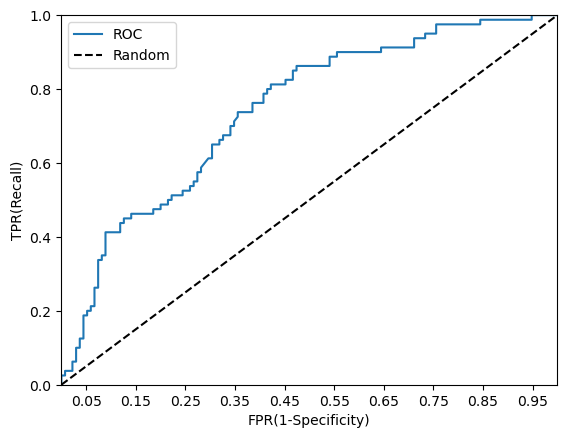

In [20]:
def roc_curve_plot(y_test, pred_proba_c1):
    #임곗값에 따른 FPR, TPR값을 반환받음.
    fprs, tprs, thresholds = roc_curve(y_test, pred_proba_c1)
    #ROC 곡선을 그래프 곡선으로 그림
    plt.plot(fprs, tprs, label='ROC')
    #가운데 대각선 직선을 그림
    plt.plot([0,1], [0,1], 'k--', label='Random')
    
    #FPR X축의 Scale을 0.1 단위로 변경, X,Y축 명 설정 등
    start, end = plt.xlim()
    plt.xticks(np.round(np.arange(start,end,0.1),2))
    plt.xlim(0,1);plt.ylim(0,1)
    plt.xlabel('FPR(1-Specificity)');plt.ylabel('TPR(Recall)')
    plt.legend()
    
roc_curve_plot(y_test, pred_proba[:,1])

In [21]:
from sklearn.metrics import roc_auc_score

pred_proba = lr_clf.predict_proba(X_test)[:,1]
roc_score = roc_auc_score(y_test, pred_proba)
print('ROC AUC 값:{0:.4f}'.format(roc_score))

ROC AUC 값:0.7425


### 임계값 변화에 따른 ROC 곡선 변화
- x축 : TPR (재현율(Recall) : 실제 True인 것들 중 True 예측한 비율))
- y축 : FPR( 실제 False 중 True로 예측한 비율)

따라서, 임계값이 높아지면 재현율이 낮아지고, FPR이 낮아진다 > ROC 곡선이 좌상단에서 우하단으로 이동한다.

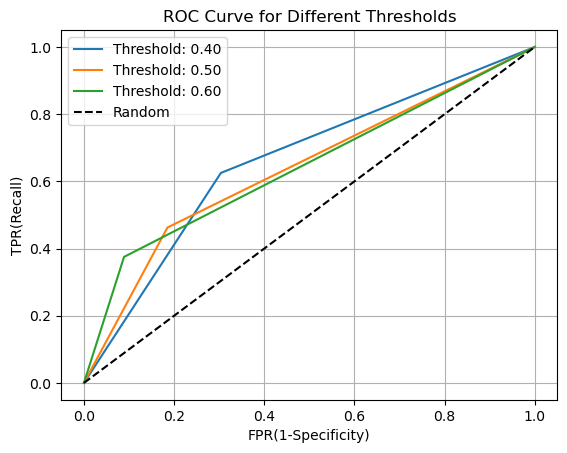

In [23]:
import matplotlib.pyplot as plt

def roc_curve_plot_with_threshold(y_test, pred_proba_c1, thresholds):
    for threshold in thresholds:
        # 임계값에 따른 예측 결과 계산
        binarized_predictions = [1 if prob >= threshold else 0 for prob in pred_proba_c1]
        # 임계값에 따른 FPR, TPR 계산
        fpr, tpr, _ = roc_curve(y_test, binarized_predictions)
        # ROC 곡선을 그래프로 그림
        plt.plot(fpr, tpr, label=f'Threshold: {threshold:.2f}')

    # 가운데 대각선 직선 그리기
    plt.plot([0, 1], [0, 1], 'k--', label='Random')
    # 그래프 스타일 설정
    plt.xlabel('FPR(1-Specificity)')
    plt.ylabel('TPR(Recall)')
    plt.title('ROC Curve for Different Thresholds')
    plt.legend()
    plt.grid(True)
    plt.show()

# 임계값 설정
thresholds = [0.4, 0.5, 0.6]
# ROC 곡선 그리기
roc_curve_plot_with_threshold(y_test, pred_proba_class1, thresholds)
